In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             mean_absolute_error, mean_squared_error, 
                             roc_curve, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')

# Data preprocessing
# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Preprocess sequence data
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Encode sequences
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Prepare the target variable
y = data['property = 1']  # Replace with the actual name of the target column

# Prepare features
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 
           'Theoretical Pi', 'Half life(hours)', 'Instability index', 
           'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 
           'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 
           'Allergenicity']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Train and evaluate the Naive Bayes classifier
gnb = GaussianNB()

gnb.fit(X_train_balanced, y_train_balanced)
y_pred = gnb.predict(X_test_combined)

Model: Gaussian Naive Bayes
Accuracy: 0.6773778920308483
Confusion Matrix:
[[182 163]
 [ 88 345]]
F1 Score: 0.7332624867162593
Recall: 0.7967667436489607
Precision: 0.6791338582677166
Mean Absolute Error: 0.3226221079691517
Root Mean Squared Error: 0.5679983344774452
ROC AUC Score: 0.6621514877665093


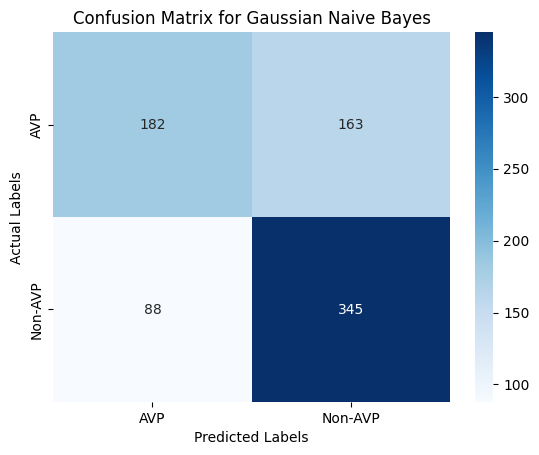

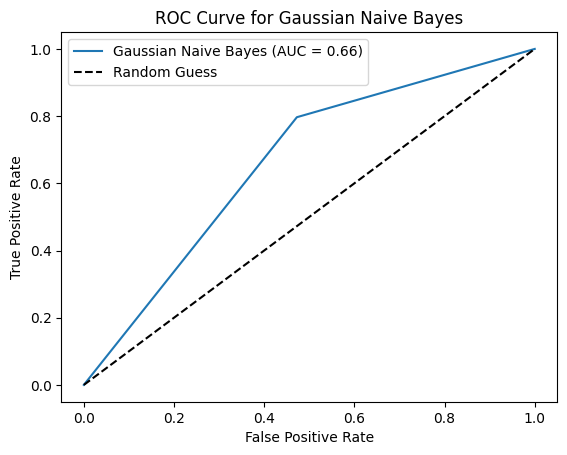

In [2]:

print("Model: Gaussian Naive Bayes")
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Calculate F1 score, precision, recall, etc.
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"ROC AUC Score: {roc_auc}")

# Create a heatmap of the confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix for Gaussian Naive Bayes")
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Gaussian Naive Bayes (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes')
plt.legend()
plt.show()